In [45]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline


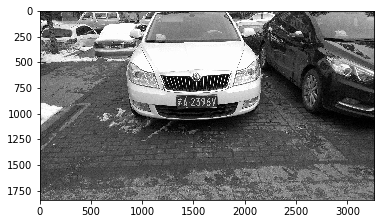

In [46]:
img = cv2.imread('11.jpg')
# cv2.imshow('img',img)
# plt.imshow(img)
# cv2.waitKey()
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,cmap='gray')

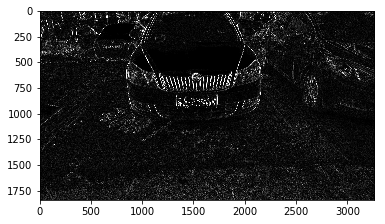

In [47]:
img_blur = cv2.GaussianBlur(img_gray,(5,5),0)
# cv2.imshow('img_blur', img_blur)
# cv2.waitKey(0)
# cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV, img_blur)
# cv2.imshow('threshold', img_thre)
# cv2.waitKey(0)
# cv2.imwrite('./thre_res.png', img_thre)
# plt.imshow(img_thre, cmap='gray')
sobel_car = cv2.Sobel(img_blur,cv2.CV_16S,1,0)
sobel_car = cv2.convertScaleAbs(sobel_car)
plt.imshow(sobel_car, cmap='gray')

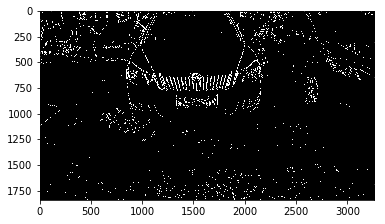

In [56]:
_, otsu_car = cv2.threshold(sobel_car,0,255,cv2.THRESH_OTSU|cv2.THRESH_BINARY)
plt.imshow(otsu_car, cmap='gray')

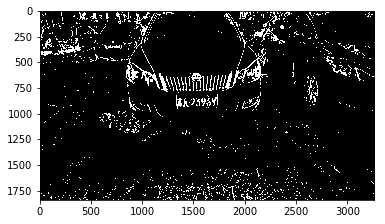

In [57]:
#Step5  闭操作
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(8,8))
close_car = cv2.morphologyEx(otsu_car,cv2.MORPH_CLOSE,kernel)
plt.imshow(close_car, cmap='gray')

In [58]:
#Step6  提取外部轮廓
contours, hierarchy = cv2.findContours(close_car,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# plt.imshow(contours)

In [50]:
# 对minAreaRect获得的最小外接矩形，用纵横比进行判断
def verifySizes(RotatedRect):
    error = 0.4
    aspect = 4.7272
    min = 15 * aspect * 15
    max = 125 * aspect * 125
    rmin = aspect - aspect * error
    rmax = aspect + aspect * error
    height,width = RotatedRect[1]
    if height==0 or width==0:
        return False
    area = height * width
    r = width/height
    if r < 1:
        r = height/width
    if (area < min or area > max) or (r < rmin or r > rmax):
        return False
    else:
        return True

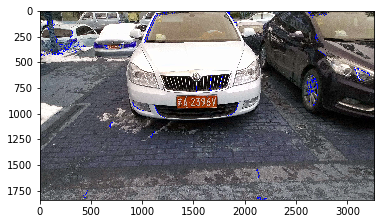

In [51]:
# 对minAreaRect获得的最小外接矩形，用纵横比进行判断
save = []  #存储合理轮廓
rectall = []  #存储对应的在最小面积矩形
 
for contour in contours:
    rect = cv2.minAreaRect(contour)
    if verifySizes(rect):
        save.append(contour)
        rectall.append(rect)

cv2.drawContours(img,save,-1,(0,0,255),2)
plt.imshow(img)

In [64]:
import numpy as np
#Step7  得到矩形中心附近随机数点
for step,rect in enumerate(rectall):
    x,y = rect[0]   #x:列数，y:行数
    x = int(x)
    y = int(y)
 
    cv2.circle(img,(x,y),3,(0,255,0),2)
 
    width, height = rect[1]
    minimum = width if width<height else height
    minimum = 0.5*minimum
 
    h,w=img.shape[:2]  #600,
 
 
    mask = np.zeros((h + 2, w + 2), dtype=np.uint8)
 
    for i in range(10):
        seed_x = int(x+0.5*(np.random.random_integers(0,100000)%int(minimum)-(minimum/2)))
        seed_y = int(y+0.5*(np.random.random_integers(0,100000)%int(minimum)-(minimum/2)))
 
        cv2.circle(img,(seed_x,seed_y),1,(0,255,255))
 
        loDiff = 7.95
        upDiff = 30
        Connectivity = 4
        flag = Connectivity + (255<<8) + cv2.FLOODFILL_MASK_ONLY
        cv2.floodFill(img,mask,(seed_x,seed_y),(255,0,0),(loDiff,loDiff,loDiff),(upDiff,upDiff,upDiff),flag)
 
    # cv2.imshow(str(step),mask)
 
    points = []
    row,column = mask.shape
 
    for i in range(row):
        for j in range(column):
            if mask[i][j]==255:
                points.append((j,i))   #点应该输入点坐标（列，行）
    points = np.asarray(points)
    new_rect = cv2.minAreaRect(points)
 
    if verifySizes(new_rect):
        # 宽,高
        x,y = new_rect[0]
        new_width, new_height = new_rect[1]
        angel = new_rect[2]
        point1 = cv2.boxPoints(new_rect)[0]
        point2 = cv2.boxPoints(new_rect)[1]
        point3 = cv2.boxPoints(new_rect)[2]
        point4 = cv2.boxPoints(new_rect)[3]
 
        # cv2.line(initial_car,tuple(point1),tuple(point2),(255,255,255),2)
        # cv2.line(initial_car, tuple(point2), tuple(point3), (255, 255, 255), 2)
        # cv2.line(initial_car, tuple(point3), tuple(point4), (255, 255, 255), 2)
        # cv2.line(initial_car, tuple(point4), tuple(point1), (255, 255, 255), 2)  #width
        rotate = cv2.getRotationMatrix2D((x,y),90+angel,1)
        res = cv2.warpAffine(initial_car,rotate,initial_car.shape[:2])
 
        #img,(列，行)，（中心）
        res = cv2.getRectSubPix(res,(int(new_height),int(new_width)),(x,y))
 
        #img,(列，行)
        res = cv2.resize(res,(105,25),interpolation=cv2.INTER_AREA)
        res = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
        res = cv2.GaussianBlur(res,(3,3),0)
        res = cv2.equalizeHist(res)
        path = 'timg.jpg'
        cv2.imwrite(path,res)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: This function is deprecated. Please call randint(0, 100000 + 1) instead
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: This function is deprecated. Please call randint(0, 100000 + 1) instead
